In [411]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy as sp
import scipy.stats
import numpy as np
import pandas
from pandas import DataFrame, Series
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
import scipy, scipy.stats
%matplotlib inline

In [339]:
# set the font size
import matplotlib
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

Importing the Data

In [340]:
temperatureDateConverter = lambda d : dt.datetime.strptime(d,'%Y-%m-%d %H:%M:%S')
temperature = np.genfromtxt('temperature.csv',delimiter=",",dtype=[('timestamp', type(dt.datetime.now)),\
('tempF', 'f8')],converters={0: temperatureDateConverter}, skip_header=1)

In [341]:
print "The variable 'temperature' is a " + str(type(temp)) + \
" and it has the following shape: " + str(temp.shape)

The variable 'temperature' is a <type 'numpy.ndarray'> and it has the following shape: (35136L,)


In [342]:
temperature.dtype.fields

<dictproxy {'tempF': (dtype('float64'), 8), 'timestamp': (dtype('O'), 0)}>

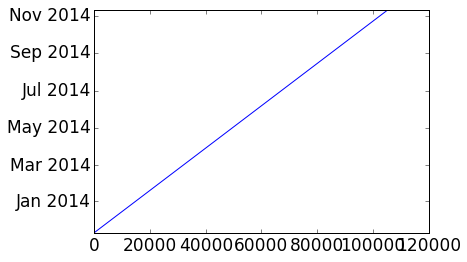

In [343]:
plt.plot(temperature['timestamp'])

In [344]:
print("The minimum difference between any two consecutive timestamps is: " +\
      str(np.min(np.diff(temperature['timestamp']))) )
print("The maximum difference between any two consecutive timestamps is: " +\
      str(np.max(np.diff(temperature['timestamp']))) ) 

The minimum difference between any two consecutive timestamps is: 0:05:00
The maximum difference between any two consecutive timestamps is: 0:05:00


In [345]:
temperature = temperature[0:-1:3]

In [346]:
print("First timestamp is on \t{}. \nLast timestamp is on \t{}.".format(\
            temperature['timestamp'][0], temperature['timestamp'][-1]))

First timestamp is on 	2013-11-10 05:00:00. 
Last timestamp is on 	2014-11-11 04:45:00.


Loading the Power Data

In [347]:
dateConverter = lambda d : dt.datetime.strptime(d,'%Y/%m/%d %H:%M:%S')
power = np.genfromtxt('Desktop/CMU Fall 15/12752 Data-Driven Building Energy \
Management/Semester Project/campusDemand1.csv',delimiter=",",names=True,\
                      dtype=['S255',dt.datetime,'f8'],converters={1: dateConverter})

In [348]:
name, indices, counts  = np.unique(power['Point_name'], return_index=True,return_counts=True)

In [349]:
for i in range(len(name)):
    print(str(name[i])+"\n\t from "+str(power[indices[i]]['Time'])+\
          " to "+str(power[indices[i]+counts[i]-1]['Time'])+"\n\t or "+\
          str(power[indices[i]+counts[i]-1]['Time']-power[indices[i]]['Time']))

Baker Hall Electric (Shark 29) - Demand Watts 
	 from 2014-02-12 07:03:27 to 2014-11-10 22:04:28
	 or 271 days, 15:01:01
Baker Hall Electric (Shark 29) - Watts
	 from 2014-11-03 00:00:24 to 2014-11-10 22:43:28
	 or 7 days, 22:43:04
Doherty Apts Electric (Shark 11) - Demand Watts
	 from 2014-10-10 09:13:56 to 2014-11-10 21:52:28
	 or 31 days, 12:38:32
Electric kW Calculations - Main Campus kW
	 from 2013-11-10 00:00:30 to 2014-11-10 22:53:27
	 or 365 days, 22:52:57
Porter Hall Electric (Shark 30) - Watts
	 from 2014-09-10 00:00:50 to 2014-11-10 22:42:28
	 or 61 days, 22:41:38
Scaife Hall Electric (Shark 21) - Watts
	 from 2014-10-10 00:00:15 to 2014-11-10 22:45:28
	 or 31 days, 22:45:13
University Center Electric (Shark 34) - Watts
	 from 2014-11-03 00:00:24 to 2014-11-10 22:48:28
	 or 7 days, 22:48:04


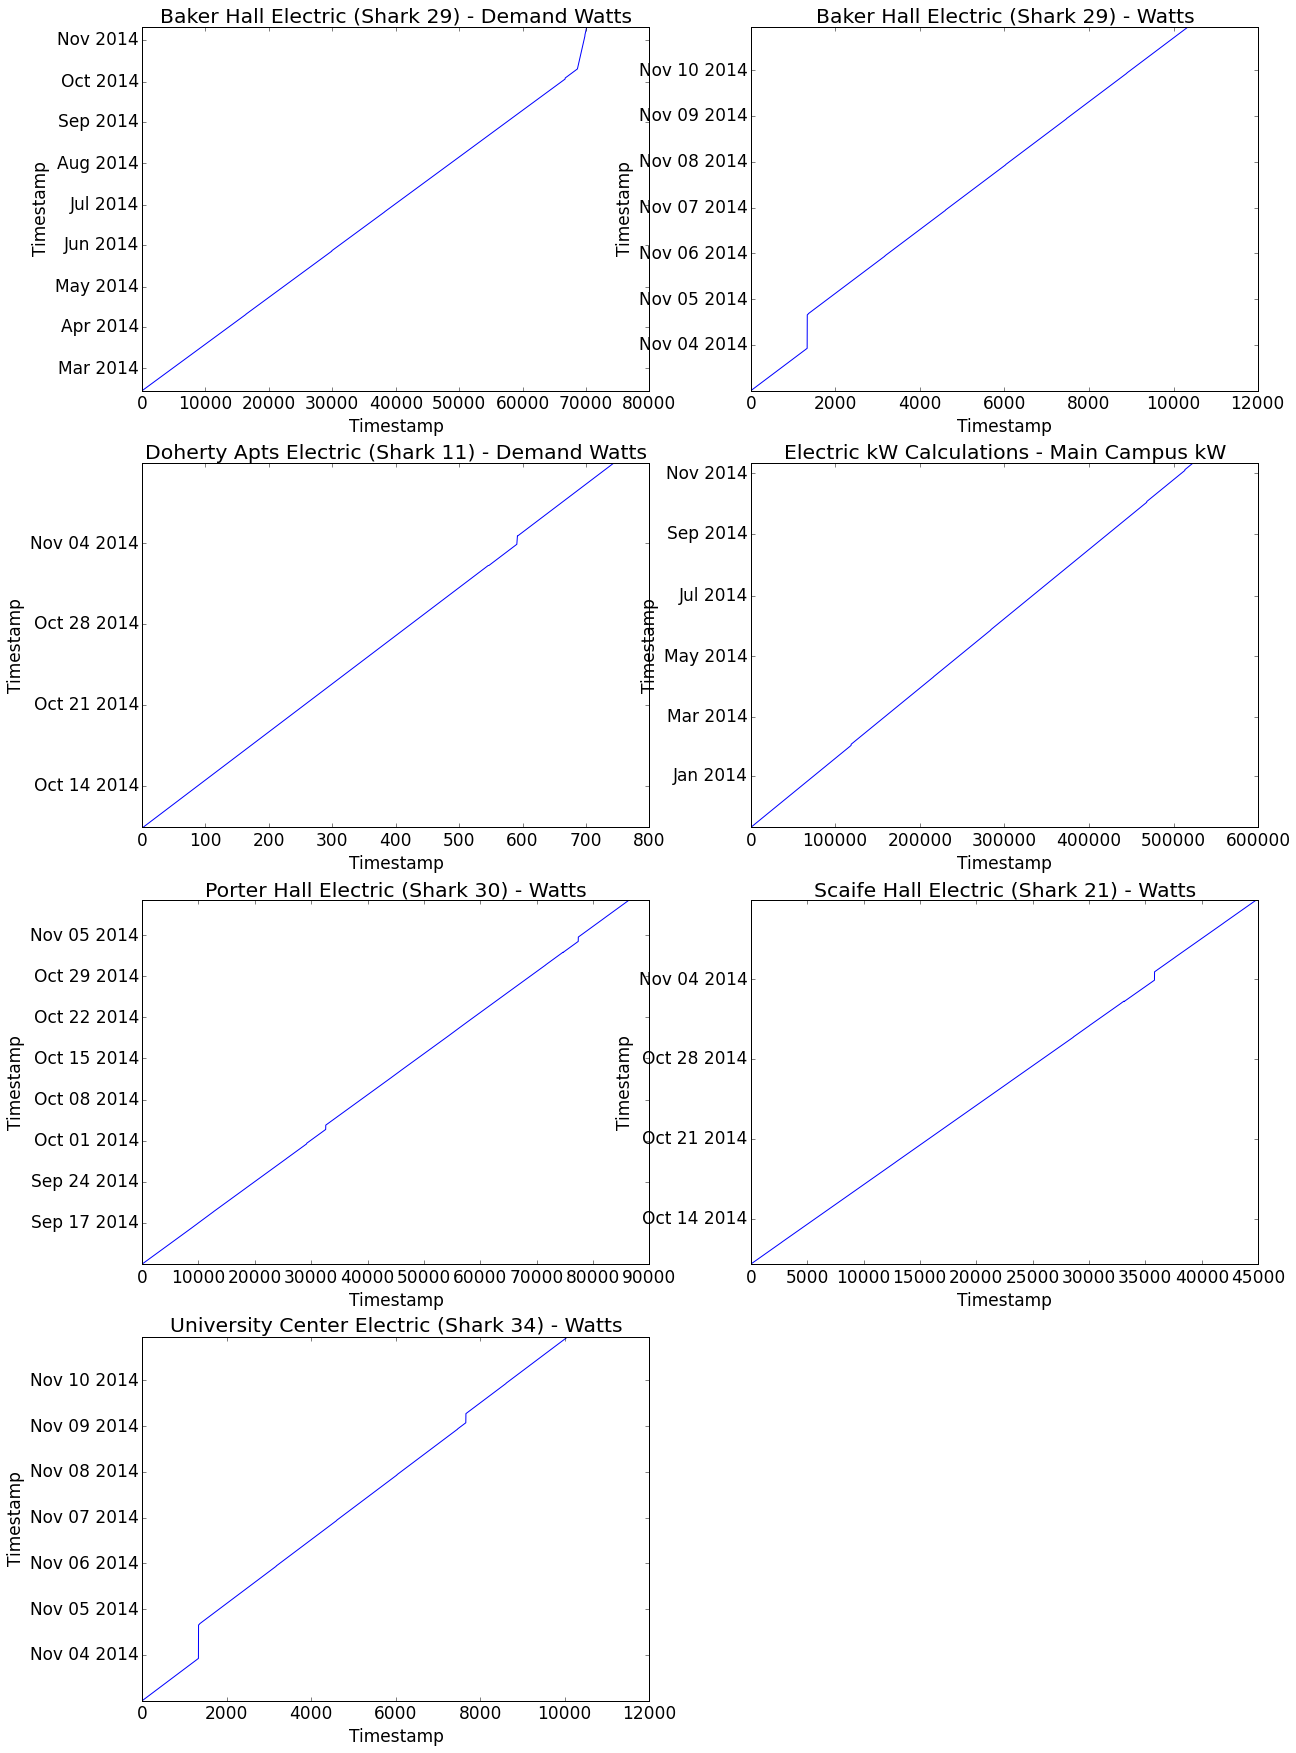

In [350]:
#Finding the gaps in the timestamps
fig = plt.figure(figsize=(20,30)) # set the figure size as 20 by 30
for meter,i in zip(name,range(len(name))):
    plt.subplot(4,2,i+1)             # 3 rows and 4 columns of subplots
    plt.plot(power[power['Point_name']==meter]['Time'])
    plt.title(meter)
    plt.xlabel('Timestamp')
    plt.ylabel('Timestamp')

Select 4 meters to make the comparisons

In [394]:
power1=power[power['Point_name']==name[3]] #Data only for power meter'Electric kW Calculations - Main Campus kW'
power2=power[power['Point_name']==name[4]] #Data only for power meter'Porter Hall Electric (Shark 30) - Watts'
power3=power[power['Point_name']==name[0]] #Data only for power meter'Baker Hall Electric (Shark 29) - Demand Watts'
power4=power[power['Point_name']==name[5]] #Data only for power meter'Doherty Apts Electric (Shark 11) - Demand Watts'

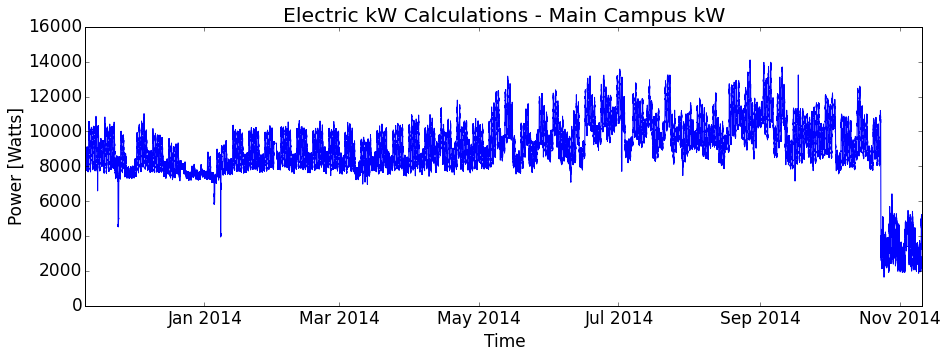

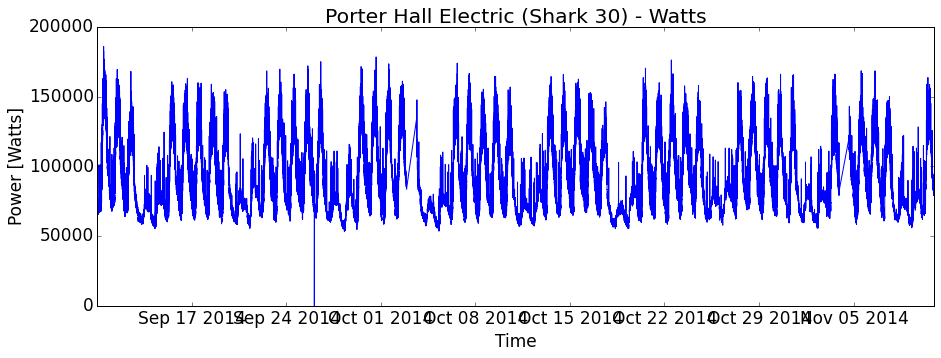

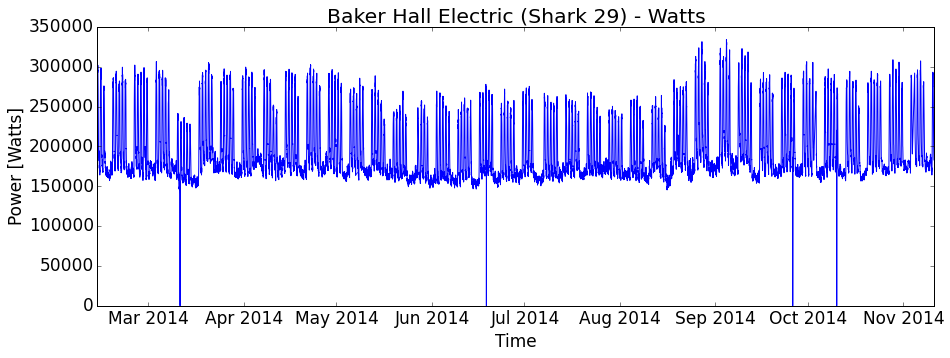

In [395]:
fig1= plt.figure(figsize=(15,5))
plt.plot(power1['Time'],power1['Value'])
plt.title(name[3])
plt.xlabel('Time')
plt.ylabel('Power [Watts]')

fig2= plt.figure(figsize=(15,5))
plt.plot(power2['Time'],power2['Value'])
plt.title(name[4])
plt.xlabel('Time')
plt.ylabel('Power [Watts]')

fig3= plt.figure(figsize=(15,5))
plt.plot(power3['Time'],power3['Value'])
plt.title(name[1])
plt.xlabel('Time')
plt.ylabel('Power [Watts]')

fig4= plt.figure(figsize=(15,5))
plt.plot(power4['Time'],power4['Value'])
plt.title(name[6])
plt.xlabel('Time')
plt.ylabel('Power [Watts]')

Harmonizing the time series

In [353]:
print("Power data from {0} to {1}.\nTemperature data from {2} to {3}"\
      .format(power1['Time'][0], power1['Time'][-1], \
        temperature['timestamp'][0], temperature['timestamp'][-1]))

Power data from 2013-11-10 00:00:30 to 2014-11-10 22:53:27.
Temperature data from 2013-11-10 05:00:00 to 2014-11-11 04:45:00


In [354]:
temperature = temperature[0:-24] 

In [355]:
def power_interp(tP, P, tT):
    # This function assumes that the input is an numpy.ndarray of datetime objects

    # Most useful interpolation tools don't work well with datetime objects
    # so we convert all datetime objects into the number of seconds elapsed
    # since 1/1/1970 at midnight (also called the UNIX Epoch, or POSIX time):
    
    toposix = lambda d: (d - dt.datetime(1970,1,1,0,0,0)).total_seconds()
    tP = list(map(toposix, tP))
    tT = list(map(toposix, tT))
    
    # Now we interpolate
    from scipy.interpolate import interp1d
    f = interp1d(tP, P,'linear')
    
    return f(tT)
    

In [356]:
newPowerValues1 = power_interp(power1['Time'], power1['Value'], temperature['timestamp'])

In [357]:
toposix = lambda d: (d - dt.datetime(1970,1,1,0,0,0)).total_seconds()

timestamp_in_seconds = map(toposix,temperature['timestamp'])
timestamps = temperature['timestamp']
temp_values = temperature['tempF']
power_values1 = newPowerValues1

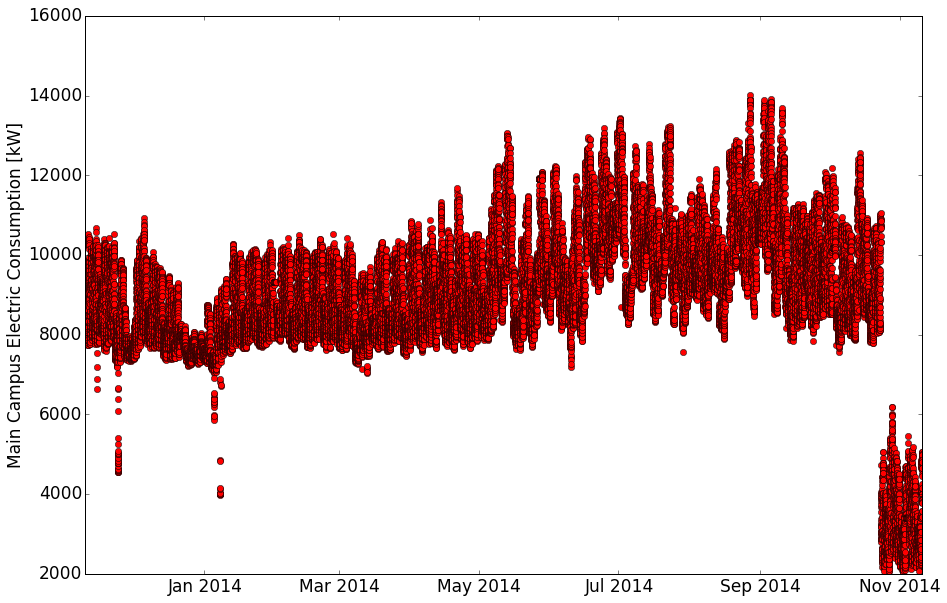

In [358]:
plt.figure(figsize=(15,10))
plt.plot(timestamps,power_values1,'ro')
plt.ylabel('Main Campus Electric Consumption [kW]')
plt.figure(figsize=(15,10))
plt.plot(timestamps, temp_values, '--b')
plt.ylabel('Outside Temperature [F]')

The consumption in Nov doesn't seem to be consistent with other months. Let's remove that part for the future analysis

In [359]:
# remove last one month: 4*24*31 pts
timestamps = timestamps[:-4*24*31]
power_values1 = power_values1[:-4*24*31]
temp_values = temp_values[:-4*24*31]

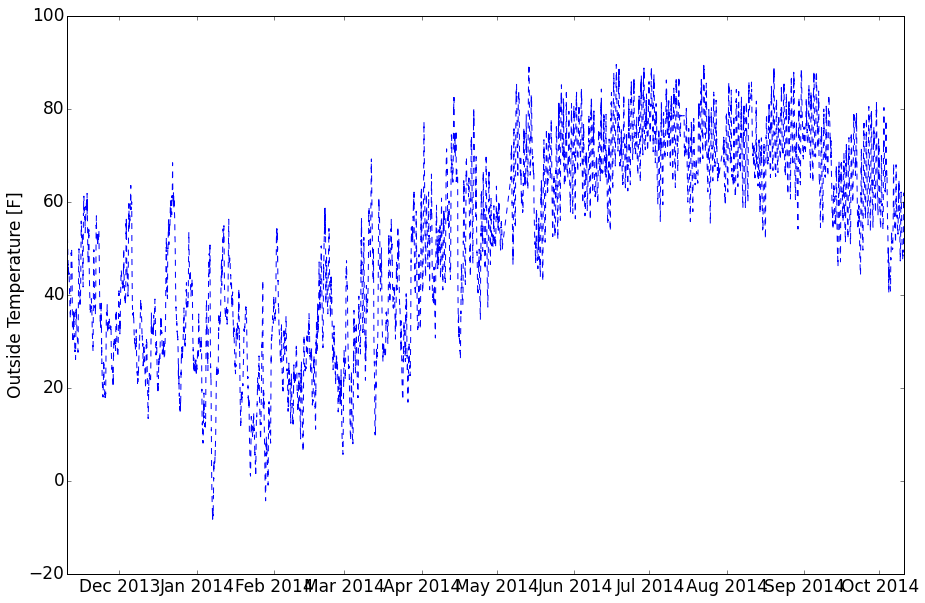

In [360]:
plt.figure(figsize=(15,10))
plt.plot(timestamps,power_values1,'ro')
plt.ylabel('Main Campus Electric Consumption [kW]')
plt.figure(figsize=(15,10))
plt.plot(timestamps, temp_values, '--b')
plt.ylabel('Outside Temperature [F]')

In [361]:
data1 = np.vstack((timestamps,power_values1,temp_values)).T

In [362]:
data1.shape

(32136L, 3L)

In [363]:
weekday = list(map(lambda t: t.weekday(), timestamps))
## Note that depending on how you do this, the result could be a tuple of ndarrays.
weekends = np.where(np.array(weekday) >= 5) 
weekdays = np.where(np.array(weekday) < 5)

In [364]:
## This is assuming you have a tuple of ndarrays
len(weekday) == len(weekends[0]) + len(weekdays[0]) 

True

In [365]:
hour = list(map(lambda t: t.hour, timestamps))
# we consider 8am to 6pm in weekdays as occupied and others as unoccupied
occupied = np.where(np.all([np.array(hour) >= 7,np.array(hour) < 18,\
                            np.array(weekday) < 5],axis=0))
unoccupied = np.where(np.any([np.array(hour) < 7,np.array(hour) >= 18,\
                              np.array(weekday) >= 5],axis=0))


In [366]:
len(hour) == len(occupied[0]) + len(unoccupied[0])

True

In [367]:
data_weekdays = data1[weekdays]
plt.figure(figsize=(15,10))
plt.boxplot([[data_weekdays[np.where(np.array([t.hour for t in data_weekdays[:,0]]\
                                             )==i)[0],1]] for i in range(24)])
plt.ylabel('Main Campus Electric Consumption [kW]')

In [368]:
hour = list(map(lambda t: t.hour, timestamps))
# we consider 9am to 11pm in weekdays as occupied and others as unoccupied
occupied = np.where(np.all([np.array(hour) >= 8,np.array(hour) < 23,\
                            np.array(weekday) < 5],axis=0))
unoccupied = np.where(np.any([np.array(hour) < 8,np.array(hour) >= 23,\
                              np.array(weekday) >= 5],axis=0))

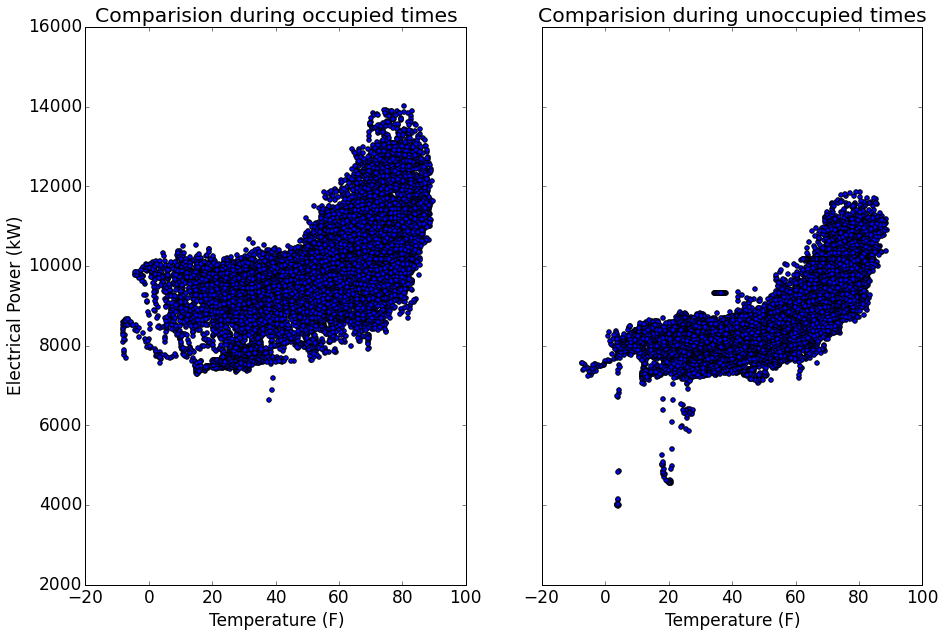

In [369]:
# plt.figure()
f, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(15,10))
ax1.scatter(data1[occupied[0],2],data1[occupied[0],1])
ax1.set_title('Comparision during occupied times')
ax1.set_ylabel('Electrical Power (kW)')
ax1.set_xlabel('Temperature (F)')
ax2.scatter(data[unoccupied[0],2],data[unoccupied[0],1])
ax2.set_title('Comparision during unoccupied times')
# ax1.set_ylabel('Electrical Power (kW)')
ax2.set_xlabel('Temperature (F)')

In [370]:
#Storing timestamps and temperature in 3 variables for the three meters
time_temp2=time_temp3=time_temp4=[temp[i][0] for i in range(len(temp))]
F_temp2=F_temp3=F_temp4=[float(temp[i][1]) for i in range(len(temp))]

Equating the timestamps for each meter(Start - End):

In [371]:
power_meter1=power1['Value']
time_meter1=power1['Time']
time_temp1=[temperature[i][0] for i in range(len(temperature))]
F_temp1=[float(temperature[i][1]) for i in range(len(temperature))]

time_new1=[];#Temporary time variables
F_new1=[]; #Temporary Temperature variables

for i in range(0,len(time_temp1)-1):
    if(time_temp1[i]<time_meter1[len(time_meter1)-1] and time_temp1[i]>time_meter1[0] ):
        time_new1.append(time_temp1[i])
        F_new1.append(F_temp1[i])

#Storing the new timestamps based on the above conditions        
time_temp1=time_new1
F_temp1=F_new1
#Converting timestamp of meter and temperature to a numerical value for interpolation
#Meter for main campus 
Time_meter1=[t.minute+t.hour*60+t.day*24*60+t.month*30*24*60+t.year*365*24*60 for t in time_meter1]
Time_temp1=[t.minute+t.hour*60+t.day*24*60+t.month*30*24*60+t.year*365*24*60 for t in time_temp1]
newpower1=np.interp(Time_temp1,Time_meter1,power_meter1)
newdata1=np.vstack((time_temp1,newpower1,F_temp1)).T 
print len(newdata1)

35111


In [372]:
power_meter2=power2['Value']
time_meter2=power2['Time']
time_temp2=[temperature[i][0] for i in range(len(temperature))]
F_temp2=[float(temperature[i][1]) for i in range(len(temperature))]

time_new2=[];#Temporary time variables
F_new2=[]; #Temporary Temperature variables

for i in range(0,len(time_temp2)-1):
    if(time_temp2[i]<time_meter2[len(time_meter2)-1] and time_temp2[i]>time_meter2[0] ):
        time_new2.append(time_temp2[i])
        F_new2.append(F_temp2[i])

#Storing the new timestamps based on the above conditions        
time_temp2=time_new2
F_temp2=F_new2
#Converting timestamp of meter and temperature to a numerical value for interpolation
#Meter for main campus 
Time_meter2=[t.minute+t.hour*60+t.day*24*60+t.month*30*24*60+t.year*365*24*60 for t in time_meter2]
Time_temp2=[t.minute+t.hour*60+t.day*24*60+t.month*30*24*60+t.year*365*24*60 for t in time_temp2]
newpower2=np.interp(Time_temp2,Time_meter2,power_meter2)
newdata2=np.vstack((time_temp2,newpower2,F_temp2)).T 
print len(newdata2)

5946


In [373]:
weekday = map(lambda t: t.weekday(), timestamps)
x=np.array(weekday)
weekends = np.where(x>=5)
weekdays = np.where(x<5)
print weekdays[0]
print weekends[0]
len(weekday) == len(weekends[0]) + len(weekdays[0]) 

[   76    77    78 ..., 32133 32134 32135]
[    0     1     2 ..., 31657 31658 31659]


True

In [374]:
hour = map(lambda t: t.hour, timestamps)
x1=np.array(hour)
occupied = np.where(np.logical_and(x1>=8, x1<19))
unoccupied = np.where(np.logical_or(x1<8, x1>=19))
print unoccupied[0]
print occupied[0]
len(hour) == len(unoccupied[0]) + len(occupied[0]) 

[    0     1     2 ..., 32133 32134 32135]
[   12    13    14 ..., 32117 32118 32119]


True

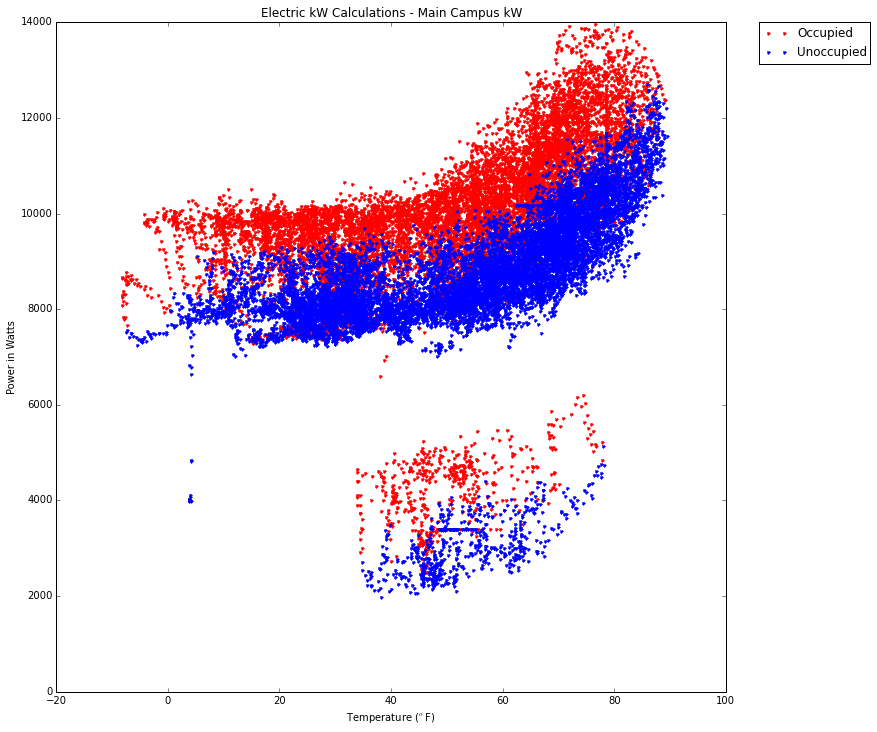

In [424]:
#Storing only the data pertaining to Mondays-Fridays
test1=[];
for i in range(len(newdata1)-1):
    if(newdata1[i][0].weekday()!=5 and newdata1[i][0].weekday()!=6):
        test1.append(newdata1[i]) 

        
newdata_1=test1

# Assuming the occupied durations for Meters(Main Campus) to be between 8am-7pm:
newdata1o=[];
newdata1u=[];
#Meter(Main Campus)
for i in range(len(newdata_1)):
    if(newdata_1[i][0].hour >= 8 and newdata_1[i][0].hour<19 ):
        newdata1o.append(newdata_1[i])
    else:
        newdata1u.append(newdata_1[i]) 

F_temp1o=[newdata1o[i][2] for i in range(len(newdata1o)-1) ]
power_temp1o=[newdata1o[i][1] for i in range(len(newdata1o)-1) ]

F_temp1u=[newdata1u[i][2] for i in range(len(newdata1u)-1) ]
power_temp1u=[newdata1u[i][1] for i in range(len(newdata1u)-1) ]

fig1 = plt.figure(figsize=(12,12))
plt.plot(F_temp1o,power_temp1o,'r.',label='Occupied')
plt.plot(F_temp1u,power_temp1u,'b.',label='Unoccupied')
plt.title( name[3])
plt.xlabel('Temperature ($^o$F)')
plt.ylabel('Power in Watts')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

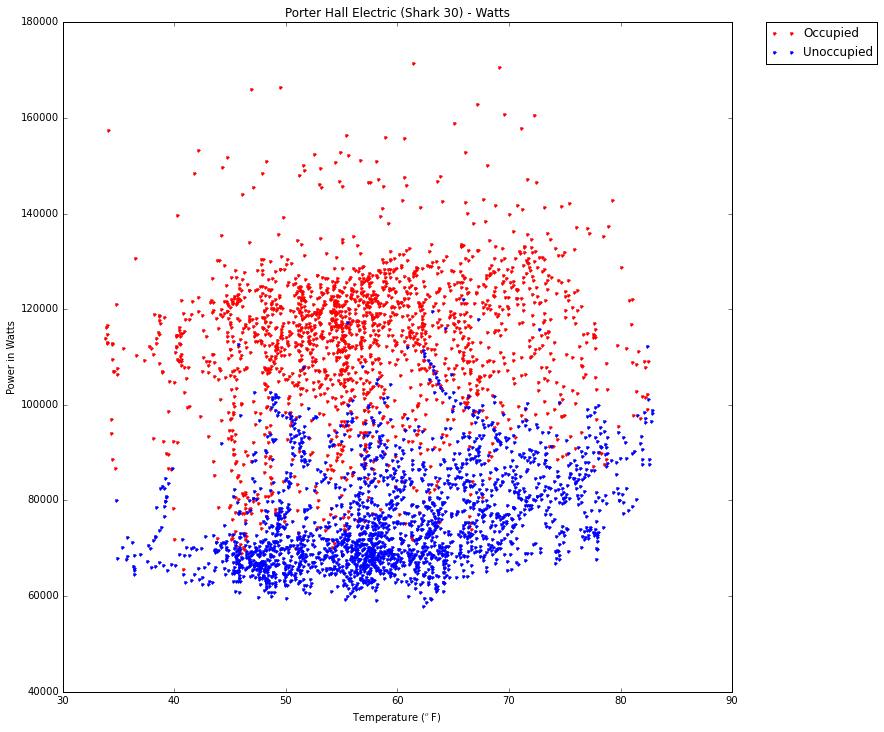

In [425]:
#Storing only the data pertaining to Mondays-Fridays
test2=[];
for i in range(len(newdata2)-1):
    if(newdata2[i][0].weekday()!=5 and newdata2[i][0].weekday()!=6):
        test2.append(newdata2[i]) 

        
newdata_2=test2

# Assuming the occupied durations for Meters(Main Campus) to be between 8am-7pm:
newdata2o=[];
newdata2u=[];
#Meter(Main Campus)
for i in range(len(newdata_2)):
    if(newdata_2[i][0].hour >= 8 and newdata_2[i][0].hour<19 ):
        newdata2o.append(newdata_2[i])
    else:
        newdata2u.append(newdata_2[i]) 

F_temp2o=[newdata2o[i][2] for i in range(len(newdata2o)-1) ]
power_temp2o=[newdata2o[i][1] for i in range(len(newdata2o)-1) ]

F_temp2u=[newdata2u[i][2] for i in range(len(newdata2u)-1) ]
power_temp2u=[newdata2u[i][1] for i in range(len(newdata2u)-1) ]

fig1 = plt.figure(figsize=(12,12))
plt.plot(F_temp2o,power_temp2o,'r.',label='Occupied')
plt.plot(F_temp2u,power_temp2u,'b.',label='Unoccupied')
plt.title( name[4])
plt.xlabel('Temperature ($^o$F)')
plt.ylabel('Power in Watts')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

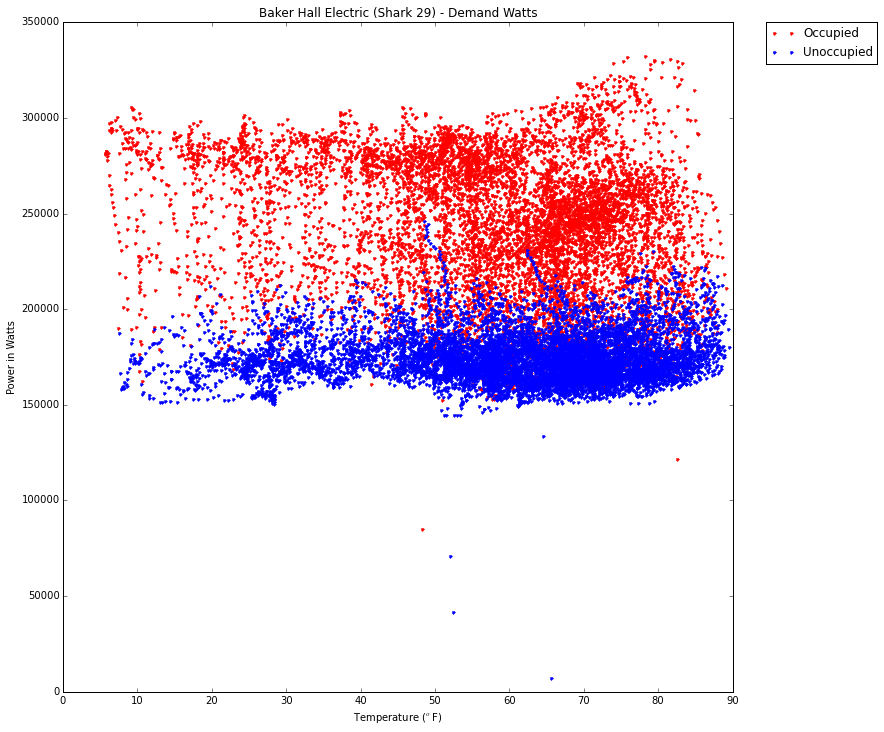

In [426]:
power_meter3=power3['Value']
time_meter3=power3['Time']
time_temp3=[temperature[i][0] for i in range(len(temperature))]
F_temp3=[float(temperature[i][1]) for i in range(len(temperature))]

time_new3=[];#Temporary time variables
F_new3=[]; #Temporary Temperature variables

for i in range(0,len(time_temp3)-1):
    if(time_temp3[i]<time_meter3[len(time_meter3)-1] and time_temp3[i]>time_meter3[0] ):
        time_new3.append(time_temp3[i])
        F_new3.append(F_temp3[i])

#Storing the new timestamps based on the above conditions        
time_temp3=time_new3
F_temp3=F_new3
#Converting timestamp of meter and temperature to a numerical value for interpolation
#Meter for main campus 
Time_meter3=[t.minute+t.hour*60+t.day*24*60+t.month*30*24*60+t.year*365*24*60 for t in time_meter3]
Time_temp3=[t.minute+t.hour*60+t.day*24*60+t.month*30*24*60+t.year*365*24*60 for t in time_temp3]
newpower3=np.interp(Time_temp3,Time_meter3,power_meter3)
newdata3=np.vstack((time_temp3,newpower3,F_temp3)).T 

#Storing only the data pertaining to Mondays-Fridays
test3=[];
for i in range(len(newdata3)-1):
    if(newdata3[i][0].weekday()!=5 and newdata3[i][0].weekday()!=6):
        test3.append(newdata3[i]) 

        
newdata_3=test3

# Assuming the occupied durations for Meters(Main Campus) to be between 8am-7pm:
newdata3o=[];
newdata3u=[];
#Meter(Main Campus)
for i in range(len(newdata_3)):
    if(newdata_3[i][0].hour >= 8 and newdata_3[i][0].hour<19 ):
        newdata3o.append(newdata_3[i])
    else:
        newdata3u.append(newdata_3[i]) 

F_temp3o=[newdata3o[i][2] for i in range(len(newdata3o)-1) ]
power_temp3o=[newdata3o[i][1] for i in range(len(newdata3o)-1) ]

F_temp3u=[newdata3u[i][2] for i in range(len(newdata3u)-1) ]
power_temp3u=[newdata3u[i][1] for i in range(len(newdata3u)-1) ]

fig1 = plt.figure(figsize=(12,12))
plt.plot(F_temp3o,power_temp3o,'r.',label='Occupied')
plt.plot(F_temp3u,power_temp3u,'b.',label='Unoccupied')
plt.title( name[0])
plt.xlabel('Temperature ($^o$F)')
plt.ylabel('Power in Watts')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

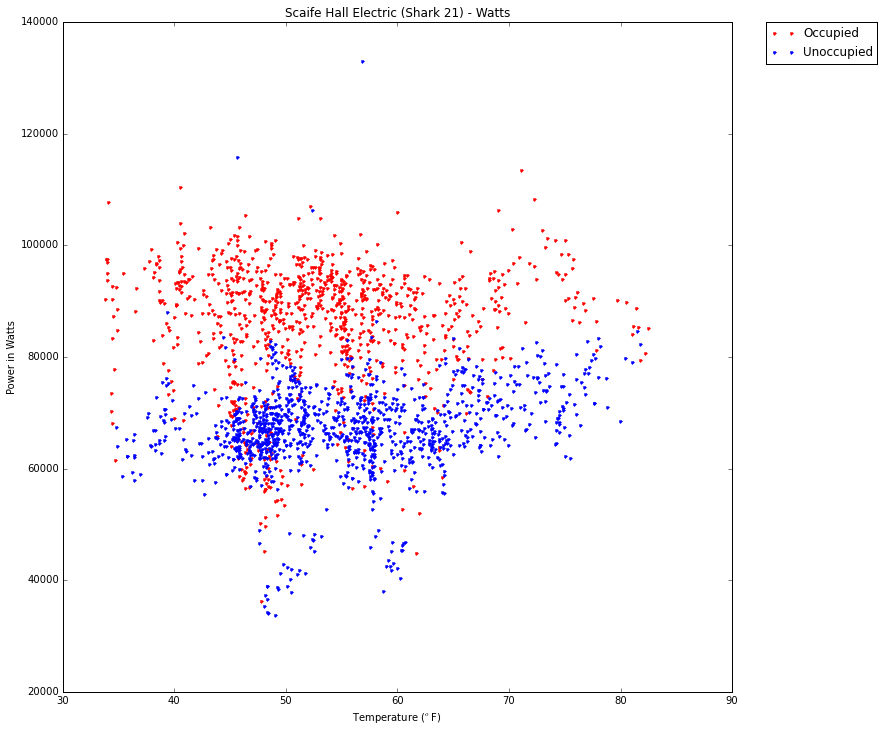

In [427]:
power_meter4=power4['Value']
time_meter4=power4['Time']
time_temp4=[temperature[i][0] for i in range(len(temperature))]
F_temp4=[float(temperature[i][1]) for i in range(len(temperature))]

time_new4=[];#Temporary time variables
F_new4=[]; #Temporary Temperature variables

for i in range(0,len(time_temp4)-1):
    if(time_temp4[i]<time_meter4[len(time_meter4)-1] and time_temp4[i]>time_meter4[0] ):
        time_new4.append(time_temp4[i])
        F_new4.append(F_temp4[i])

#Storing the new timestamps based on the above conditions        
time_temp4=time_new4
F_temp4=F_new4
#Converting timestamp of meter and temperature to a numerical value for interpolation
#Meter for main campus 
Time_meter4=[t.minute+t.hour*60+t.day*24*60+t.month*30*24*60+t.year*365*24*60 for t in time_meter4]
Time_temp4=[t.minute+t.hour*60+t.day*24*60+t.month*30*24*60+t.year*365*24*60 for t in time_temp4]
newpower4=np.interp(Time_temp4,Time_meter4,power_meter4)
newdata4=np.vstack((time_temp4,newpower4,F_temp4)).T 

#Storing only the data pertaining to Mondays-Fridays
test4=[];
for i in range(len(newdata4)-1):
    if(newdata4[i][0].weekday()!=5 and newdata4[i][0].weekday()!=6):
        test4.append(newdata4[i]) 

        
newdata_4=test4

# Assuming the occupied durations for Meters(Main Campus) to be between 8am-7pm:
newdata4o=[];
newdata4u=[];
#Meter(Main Campus)
for i in range(len(newdata_4)):
    if(newdata_4[i][0].hour >= 8 and newdata_4[i][0].hour<19 ):
        newdata4o.append(newdata_4[i])
    else:
        newdata4u.append(newdata_4[i]) 

F_temp4o=[newdata4o[i][2] for i in range(len(newdata4o)-1) ]
power_temp4o=[newdata4o[i][1] for i in range(len(newdata4o)-1) ]

F_temp4u=[newdata4u[i][2] for i in range(len(newdata4u)-1) ]
power_temp4u=[newdata4u[i][1] for i in range(len(newdata4u)-1) ]

fig1 = plt.figure(figsize=(12,12))
plt.plot(F_temp4o,power_temp4o,'r.',label='Occupied')
plt.plot(F_temp4u,power_temp4u,'b.',label='Unoccupied')
plt.title( name[5])
plt.xlabel('Temperature ($^o$F)')
plt.ylabel('Power in Watts')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [379]:
def Tc(temperature1, a):
    # The return value will be a matrix with as many rows as the temperature
    # array, and as many columns as len(T_bound) [assuming that 0 is the first boundary]
    Ti=[temperature1[i][2] for i in range(len(temperature1))]
    step=np.linspace(np.min(Ti),np.max(Ti),6)
    T_bound=np.arange(a);
    T_bound=step[0:a]
    A = np.zeros(6)
    Tc_matrix = []
    #
    for i in range(0,len(Ti)):
            if(Ti[i]<T_bound[0]):
                A[0]=Ti[i]
            else:
                A[0]=T_bound[0]
                if(Ti[i]<T_bound[1]):
                    A[1]=Ti[i]-T_bound[0]
                else:
                    A[1]=T_bound[1]-T_bound[0]
                    if(Ti[i]<T_bound[2]):
                        A[2]=Ti[i]-T_bound[1]
                    else:
                        A[2]=T_bound[2]-T_bound[1]
                        if(Ti[i]<T_bound[3]):
                            A[3]=Ti[i]-T_bound[2]
                        else:
                            A[3]=T_bound[3]-T_bound[2]
                            if(Ti[i]<T_bound[4]):
                                A[4]=Ti[i]-T_bound[3]
                            else:
                                A[4]=T_bound[4]-T_bound[3]
                                A[5]=Ti[i]-T_bound[4]
            Tc_matrix.append(A)
            A = np.zeros(6)
            
    return Tc_matrix
print len(Tc(newdata_1, 5))

25050


In [380]:
def DesignMatrix(temperature1, a, b):
    aa=np.zeros(a)
    c=[]
    for i in range(0,len(aa)):
        aa[i]=1
        c.append(aa)
        aa=np.zeros(a)
    c_1=c
    for i in range((len(temperature1)-1)/a):
        c_1=np.vstack((c_1,c))
    coeff=c_1[0:len(temperature1)]
    A= np.hstack((Tc(temperature1, b),coeff))
    X = np.matrix(A)
    return X
print DesignMatrix(newdata_1, 480, 5)

[[ -8.268   19.5614  19.5614 ...,   0.       0.       0.    ]
 [ -8.268   19.5614  19.5614 ...,   0.       0.       0.    ]
 [ -8.268   19.5614  19.5614 ...,   0.       0.       0.    ]
 ..., 
 [ -8.268   19.5614  19.5614 ...,   0.       0.       0.    ]
 [ -8.268   19.5614  19.5614 ...,   0.       0.       0.    ]
 [ -8.268   19.5614  19.5614 ...,   0.       0.       0.    ]]


In [381]:
def beta_hat(powervalues, a, b):
    y = [powervalues[i][1] for i in range(len(powervalues))]
    Y =np.matrix(y).T
    X= DesignMatrix(powervalues, a, b)
    beta = np.linalg.inv(X.T*X)*(X.T)*Y
    return beta
print beta_hat(newdata_1, 480, 5)

[[ -290.15537722]
 [   12.38582898]
 [  -12.77773091]
 [  -17.13988186]
 [  102.52438112]
 [   87.18652281]
 [ 5247.33177441]
 [ 5022.9839641 ]
 [ 4863.39006251]
 [ 6029.09750213]
 [ 6090.47768842]
 [ 5480.81572324]
 [ 6283.09158958]
 [ 5624.36723548]
 [ 5253.52697765]
 [ 4904.06925228]
 [ 4819.95666977]
 [ 5703.823757  ]
 [ 5363.4027784 ]
 [ 6391.54703719]
 [ 5835.92495452]
 [ 4827.47153631]
 [ 6009.11495428]
 [ 5624.50455821]
 [ 4809.95091327]
 [ 5343.53920385]
 [ 5724.44691038]
 [ 5951.22508229]
 [ 6098.39377814]
 [ 6021.5458938 ]
 [ 5409.84654722]
 [ 6076.54006294]
 [ 6308.81187019]
 [ 5887.50441101]
 [ 5555.87206305]
 [ 5954.71399551]
 [ 5571.46457244]
 [ 6622.61528428]
 [ 6277.20577799]
 [ 6792.79996424]
 [ 5939.48625837]
 [ 6852.10488791]
 [ 6554.05792322]
 [ 7653.93841044]
 [ 6717.940585  ]
 [ 7784.15912868]
 [ 7621.12801673]
 [ 7466.42656448]
 [ 7244.69098282]
 [ 7793.76667354]
 [ 7245.40793143]
 [ 7923.14331118]
 [ 8068.99010574]
 [ 8328.90005719]
 [ 7625.93487903]
 [ 7580.81

In [455]:
#Storing only the unoccupied weekend data
testData1=[];
for i in range(len(newdata1)-1):
    if(newdata1[i][0].weekday()!=0 and newdata1[i][0].weekday()!=1 and newdata1[i][0].weekday()!=2
      and newdata1[i][0].weekday()!=3 and newdata1[i][0].weekday()!=4):
        testData1.append(newdata1[i]) 

newData=testData1

# Assuming the occupied durations for Meters(Main Campus) to be between 9am-7pm:
testDatao=[];
testDatau=[];
trainData=[];
#Meter(Main Campus)
for i in range(len(newData)):
    if(newData[i][0].hour >= 8 and newData[i][0].hour<18 ):
        testDatao.append(newData[i])
    else:
        testDatau.append(newData[i]) 
print len(testDatau)
print testDatau
trainData = testDatao


5860
[array([datetime.datetime(2013, 11, 10, 5, 0), 7830.57475, 54.43], dtype=object), array([datetime.datetime(2013, 11, 10, 5, 15), 7827.659375, 54.648], dtype=object), array([datetime.datetime(2013, 11, 10, 5, 30), 7893.324625, 54.734], dtype=object), array([datetime.datetime(2013, 11, 10, 5, 45), 7820.91825, 54.516], dtype=object), array([datetime.datetime(2013, 11, 10, 6, 0), 7910.784375, 54.212], dtype=object), array([datetime.datetime(2013, 11, 10, 6, 15), 7886.923125, 53.865], dtype=object), array([datetime.datetime(2013, 11, 10, 6, 30), 7878.6410000000005, 53.341], dtype=object), array([datetime.datetime(2013, 11, 10, 6, 45), 7927.903, 53.515], dtype=object), array([datetime.datetime(2013, 11, 10, 7, 0), 7867.386875, 53.472], dtype=object), array([datetime.datetime(2013, 11, 10, 7, 15), 7834.395125, 53.121], dtype=object), array([datetime.datetime(2013, 11, 10, 7, 30), 7858.464250000001, 52.554], dtype=object), array([datetime.datetime(2013, 11, 10, 7, 45), 7906.963625, 52.378

In [456]:
Ti=[testDatao[i][2] for i in range(len(testDatao))]
step=np.linspace(np.min(Ti),np.max(Ti),6)
T_bound=np.arange(5);
T_bound=step[0:5]

In [457]:
print len(Tc(trainData, 5))
print DesignMatrix(trainData, 481, 5)
print len(DesignMatrix(trainData, 481, 5))
print DesignMatrix(trainData, 481, 5).shape

4200
[[  8.78        15.63586706  15.63586706 ...,   0.           0.           0.        ]
 [  8.78        15.63586706  15.63586706 ...,   0.           0.           0.        ]
 [  8.78        15.63586706  15.63586706 ...,   0.           0.           0.        ]
 ..., 
 [  8.78        15.63586706  15.63586706 ...,   0.           0.           0.        ]
 [  8.78        15.63586706  15.63586706 ...,   0.           0.           0.        ]
 [  8.78        15.63586706  15.63586706 ...,   0.           0.           0.        ]]
4200
(4200L, 487L)


In [458]:
print beta_hat(trainData, 481, 5).shape
print beta_hat(trainData, 481, 5)

(487L, 1L)
[[  -562.20231936]
 [   372.88118379]
 [   -78.91555988]
 [    35.36776811]
 [   170.65487376]
 [   -93.08446493]
 [  8539.1571682 ]
 [  8017.41759926]
 [ 11554.72501008]
 [  8186.87159546]
 [  6270.64394189]
 [  4495.60921934]
 [  5902.71663708]
 [  8402.77076646]
 [  9221.81294496]
 [  7132.12167428]
 [  9802.68031721]
 [  8287.98041907]
 [  6422.45487838]
 [  5073.36193331]
 [  8217.13258804]
 [  8522.50985598]
 [  8879.57620384]
 [  9468.93386483]
 [  7387.84874681]
 [  9997.74133789]
 [  6355.77584597]
 [  5619.18233864]
 [  8163.28730206]
 [  5761.77884196]
 [  7899.76455464]
 [  7913.39727632]
 [  7889.92003146]
 [  8403.69416704]
 [  6920.81654925]
 [  6957.96420167]
 [  6823.78022516]
 [  8233.48956083]
 [  6571.10132724]
 [  9046.73966293]
 [  6095.93436726]
 [  7315.4398776 ]
 [  9352.57677766]
 [  7725.33567361]
 [  5107.54635113]
 [  5933.44597239]
 [  8535.53290567]
 [  5432.88781724]
 [  6059.49583412]
 [  7195.61000259]
 [  9600.1683534 ]
 [  9629.98602524]
 

In [459]:
powernew=[trainData[i][1] for i in range(len(trainData)-1) ]
load= DesignMatrix(trainData, 481, 5)*beta_hat(trainData, 481, 5)
time_temp=[trainData[i][0] for i in range(len(trainData)-1) ]
load_predu=np.arange(len(time_temp))

for i in range(0,len(time_temp)):
    load_predu[i]=load[i]
print len(load_predu)
print len(power)
print load_predu

4199
744892
[ 8626  8095 11627 ...,  7579  8032  6824]


In [460]:
fig = plt.figure(figsize=(15,15))
plt.plot(time_temp,load_predu,'-',label='Predicted Load')
plt.plot(time_temp,powernew,'-',label='Actual Load')
plt.title(name[3])
plt.xlabel('Time')
plt.ylabel('Power in Watts')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [461]:
#Storing only the unoccupied weekend data
testData2=[];
for i in range(len(newdata2)-1):
    if(newdata2[i][0].weekday()!=0 and newdata2[i][0].weekday()!=1 and newdata2[i][0].weekday()!=2
      and newdata2[i][0].weekday()!=3 and newdata2[i][0].weekday()!=4):
        testData2.append(newdata2[i]) 

newData=testData2

# Assuming the occupied durations for Meters(Main Campus) to be between 9am-7pm:
testDatao=[];
testDatau=[];
trainData=[];
#Meter(Main Campus)
for i in range(len(newData)):
    if(newData[i][0].hour >= 8 and newData[i][0].hour<18 ):
        testDatao.append(newData[i])
    else:
        testDatau.append(newData[i]) 
print len(testDatau)
print testDatau
trainData = testDatao

1008
[array([datetime.datetime(2014, 9, 13, 0, 0), 68745.015625, 61.43095], dtype=object), array([datetime.datetime(2014, 9, 13, 0, 15), 69215.1328125, 60.9], dtype=object), array([datetime.datetime(2014, 9, 13, 0, 30), 68481.234375, 60.54067], dtype=object), array([datetime.datetime(2014, 9, 13, 0, 45), 65443.4765625, 60.140667], dtype=object), array([datetime.datetime(2014, 9, 13, 1, 0), 66901.5859375, 59.54067], dtype=object), array([datetime.datetime(2014, 9, 13, 1, 15), 61327.41796875, 58.9601669], dtype=object), array([datetime.datetime(2014, 9, 13, 1, 30), 60997.0546875, 58.8101654], dtype=object), array([datetime.datetime(2014, 9, 13, 1, 45), 64354.61328125, 58.1601677], dtype=object), array([datetime.datetime(2014, 9, 13, 2, 0), 61419.25390625, 58.0101662], dtype=object), array([datetime.datetime(2014, 9, 13, 2, 15), 62123.94140625, 57.86017], dtype=object), array([datetime.datetime(2014, 9, 13, 2, 30), 61520.15625, 57.8], dtype=object), array([datetime.datetime(2014, 9, 13, 2

In [462]:
Ti=[testDatao[i][2] for i in range(len(testDatao))]
step=np.linspace(np.min(Ti),np.max(Ti),6)
T_bound=np.arange(5);
T_bound=step[0:5]
print T_bound

[ 31.28      40.517134  49.754268  58.991402  68.228536]


In [463]:
powernew=[trainData[i][1] for i in range(len(trainData)-1) ]
load= DesignMatrix(trainData, 481, 5)*beta_hat(trainData, 481, 5)
time_temp=[trainData[i][0] for i in range(len(trainData)-1) ]
load_predu=np.arange(len(time_temp))

for i in range(0,len(time_temp)):
    load_predu[i]=load[i]
print len(load_predu)
print len(power)
print load_predu

719
744892
[ 79472  85610  75656  74685  82811  64306  81608  75902 104150  88313
  74391  87395  80619 101975  95558  92229  83112  94059  95108  96412
  97588  95872  93522 111250  91110 100728 103786 106461  98818  97464
 106241  99693  98969  88656  98718 106896  86911  95326  92965  88531
  92355  87784  72764  71244  94927  73405  82356  93166 101314  81730
  93919  94820  96675  89227  85531  95352 100074  96365  85503 102579
  94737  96599  93739 107352  89179 100508 114452  99443  99019  99689
  98881 107456 108108 105668  99412 112283 109431 111900 101219  98835
  98605  92974  98044 104769  86396  85873  82412  97296  98790  89742
  87330  97205  99619  91895  98473  97801 102366 108188 104436  90680
  87045  97840 102225 106427  97040 102785 101368  94342  83651  92312
 103986  87899 102712  93572  95488  89137  94929 108011 101483  92215
  80697  70339  63784  76778  80251  83498  83840  88425  85374  85011
  92931  94300 103949  95558  98676  94847  96057 100606 122446 10

In [464]:
fig = plt.figure(figsize=(15,15))
plt.plot(time_temp,load_predu,'-',label='Predicted Load')
plt.plot(time_temp,powernew,'-',label='Actual Load')
plt.title(name[4])
plt.xlabel('Time')
plt.ylabel('Power in Watts')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

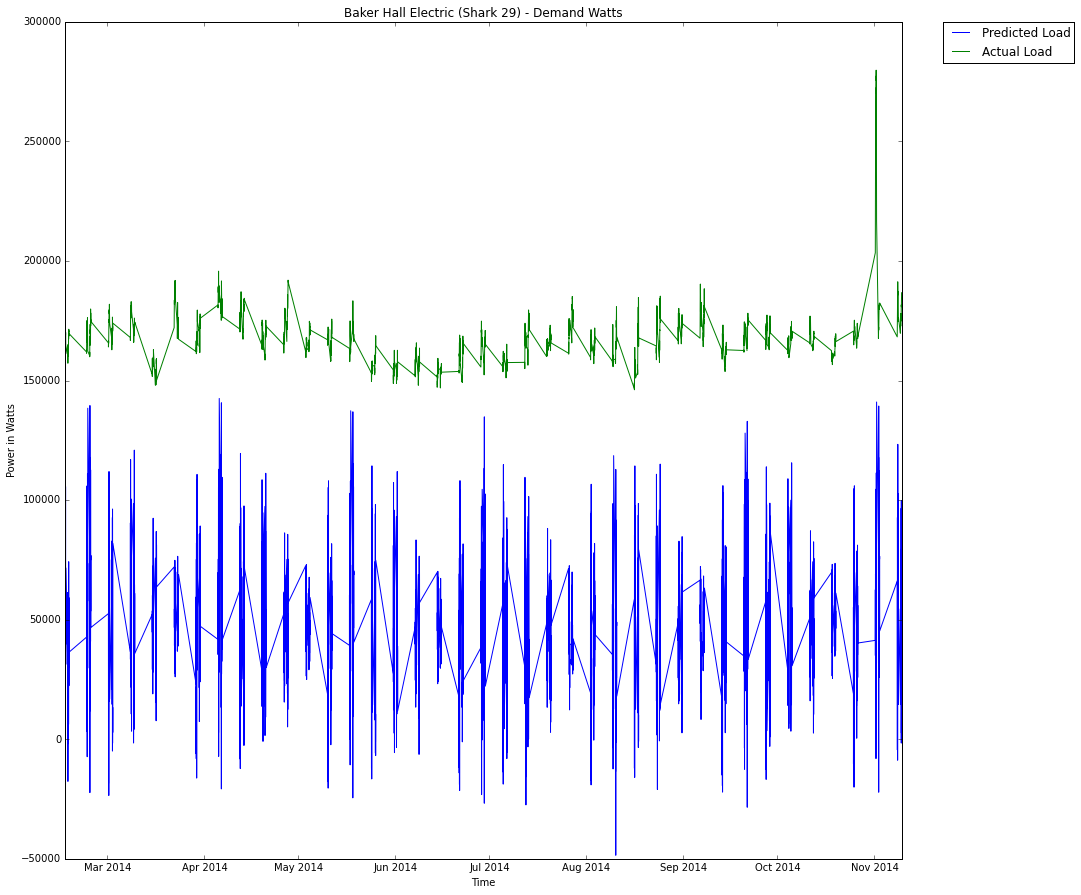

In [465]:
#Storing only the unoccupied weekend data
testData3=[];
for i in range(len(newdata3)-1):
    if(newdata3[i][0].weekday()!=0 and newdata3[i][0].weekday()!=1 and newdata3[i][0].weekday()!=2
      and newdata3[i][0].weekday()!=3 and newdata3[i][0].weekday()!=4):
        testData3.append(newdata3[i]) 

newData=testData3

# Assuming the occupied durations for Meters(Main Campus) to be between 9am-7pm:
testDatao=[];
testDatau=[];
trainData=[];

for i in range(len(newData)):
    if(newData[i][0].hour >= 8 and newData[i][0].hour<18 ):
        testDatao.append(newData[i])
    else:
        testDatau.append(newData[i]) 

trainData = testDatao
Ti=[testDatao[i][2] for i in range(len(testDatao))]
step=np.linspace(np.min(Ti),np.max(Ti),6)
T_bound=np.arange(5);
T_bound=step[0:5]

powernew=[trainData[i][1] for i in range(len(trainData)-1) ]
load= DesignMatrix(trainData, 480, 5)*beta_hat(trainData, 480, 5)
time_temp=[trainData[i][0] for i in range(len(trainData)-1) ]
load_predu=np.arange(len(time_temp))

for i in range(0,len(time_temp)):
    load_predu[i]=load[i]
# print len(load_predu)
# print len(power)
# print load_predu
fig = plt.figure(figsize=(15,15))
plt.plot(time_temp,load_predu,'-',label='Predicted Load')
plt.plot(time_temp,powernew,'-',label='Actual Load')
plt.title(name[0])
plt.xlabel('Time')
plt.ylabel('Power in Watts')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

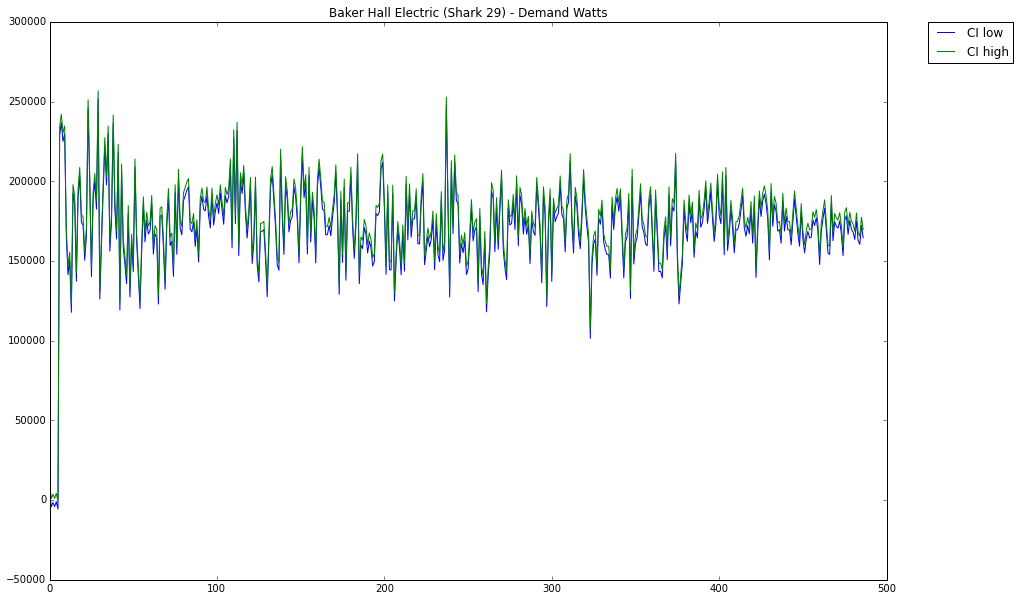

In [466]:
betahat = beta_hat(trainData, 481, 5)
dof = len(betahat)-len(betahat[0])
zvalue=scipy.stats.t.ppf(0.975,dof)

std=np.std(betahat)
se=std/np.sqrt(len(betahat))

CIlow=betahat - zvalue * se
CIhigh=betahat + zvalue * se

timestamp=[t.minute+t.hour*60 for t in time_temp]
indices=[];
indices.append(0)

Max=np.max(timestamp)

for i in range(len(time_temp)-1):
    if(timestamp[i]==Max):
        indices.append(i)
indices.append(len(time_temp)-1)
    

x14=np.arange(0,len(CIlow))

fig1 = plt.figure(figsize=(15,10))
plt.plot(x14,CIlow,'-',label='CI low')
plt.plot(x14,CIhigh,'-',label='CI high')
plt.title(name[0])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

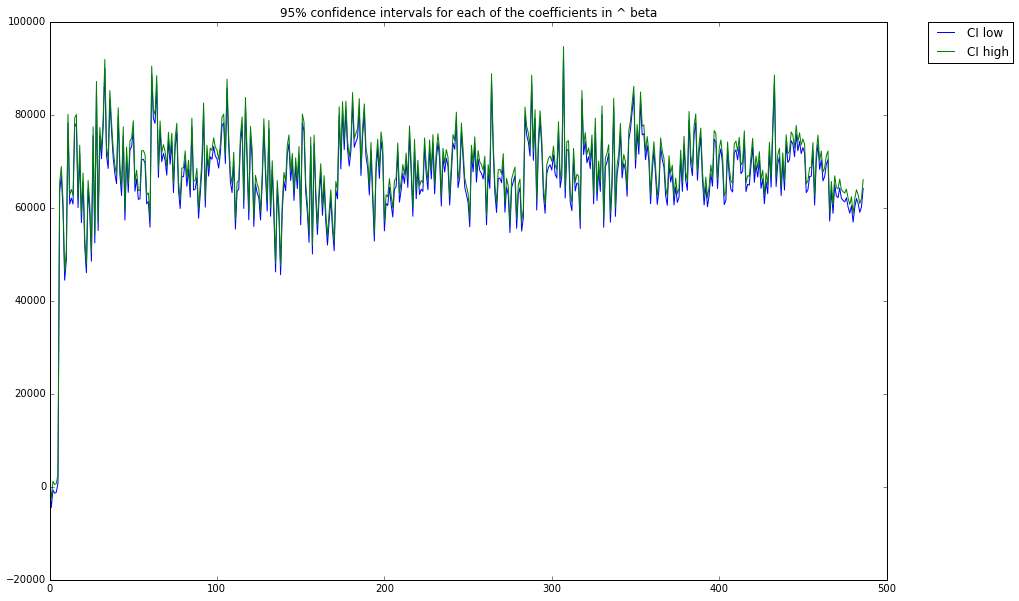

In [420]:
betahat = beta_hat(trainData, 481, 5)
dof = len(betahat)-len(betahat[0])
zvalue=scipy.stats.t.ppf(0.975,dof)

std=np.std(betahat)
se=std/np.sqrt(len(betahat))

CIlow=betahat - zvalue * se
CIhigh=betahat + zvalue * se

timestamp=[t.minute+t.hour*60 for t in time_temp]
indices=[];
indices.append(0)

Max=np.max(timestamp)

for i in range(len(time_temp)-1):
    if(timestamp[i]==Max):
        indices.append(i)
indices.append(len(time_temp)-1)
    

x14=np.arange(0,len(CIlow))

fig1 = plt.figure(figsize=(15,10))
plt.plot(x14,CIlow,'-',label='CI low')
plt.plot(x14,CIhigh,'-',label='CI high')
plt.title('95% confidence intervals for each of the coefficients in ^ beta')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)